In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
import geopandas as gpd
from warnings import filterwarnings
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import kendalltau
from geopy import distance
import collections
from itertools import product

In [4]:
import ipystata
from ipystata.config import config_stata
config_stata('/home/ubuntu/stata/stata-mp')  

IPyStata is loaded in batch mode.


In [4]:
def latLonToCartesian(args):
    """
    ???
    """
    latrad = 0.017453*args[0]
    lonrad = 0.017453*args[1]
    return (6371*np.cos(latrad)*np.cos(lonrad), 
            6371*np.cos(latrad)*np.sin(lonrad), 
            6371*np.sin(latrad))

In [5]:
# Hungarian cities connected to iwiw's city id (CityId) with some metadata
cities = pd.read_csv('../iwiw_data/cities_final.csv')
cities['CoordinateLatLon'] = list(zip(cities.Latitude, cities.Longitude))
cities['CoordinateXY'] = list(map(latLonToCartesian, list(zip(cities.Latitude, cities.Longitude))))

# user dataframe
df_orig = pd.read_csv('../iwiw_data/UsersWithNumOfConnections_Cleaned.csv', sep = '\t')
# selecting relecant columns
df_orig = df_orig[['Id', 'InvitorId', 'RegistrationDate', 'LastLoginDate', 'CountryId', 'CityId', 
                   'NumOfConnections', 'BirthYear']]
# parsing adoption and churn dates
df_orig['RegistrationDate'] =  pd.to_datetime(df_orig['RegistrationDate'], format='%Y-%m-%d')
df_orig['LastLoginDate'] =  pd.to_datetime(df_orig['LastLoginDate'], format='%Y-%m-%d')
len_orig = len(df_orig)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11,12,13,14,15,17,25,27,29,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# keep only the users with:
    # more than 0 connections --> This might be pointless to filter, 
                                 # since if everyone has at least one connection,
                                 # its invitor. If its invitor deleted itself, then the line is dropped
                                 # anyways by the InvitorId criteria
    # has less than 5000 connections --> people with this much connection are probably spam account creators
    # its real invitor id is known
    # used iWiW at least for a day
# length df_orig: 4.576.664
print('Original data length: {}\n'.format(len_orig))
df_filtered = df_orig[(df_orig['NumOfConnections'] > 0) &
                (df_orig['NumOfConnections'] < 5000) &
                (df_orig['InvitorId'] != 100000000.0) &
                (df_orig['RegistrationDate'] != df_orig['LastLoginDate'])].dropna(subset = ['InvitorId']).drop_duplicates(subset = ['Id'])
len_necessary_filters = len(df_filtered)
print('Length after necessary filters: {}'.format(len_necessary_filters))
print('{} users lost in this step'.format(len_orig-len_necessary_filters))
print('{} users lost in total\n'.format(len_orig-len_necessary_filters))

# Filter users who are not in Hungary, the resulting dataframe has 3.704.879 records
df_filtered['InvitorId'] = df_filtered['InvitorId'].map(int)
df_filtered=df_filtered[df_filtered['CountryId'] == 110]
len_non_hungary = len(df_filtered)
print('Length after dropping users outside Hungary: {}'.format(len_non_hungary))
print('{} users lost in this step'.format(len_necessary_filters-len_non_hungary))
print('{} users lost in total\n'.format(len_orig-len_non_hungary))

# 2685 unique CityId after mapping (min CityId = 10, max CityId = 138163)
# 2555 unique CityId in the file provided by Balázs (min CityId = 379, max CityId = 138163)
# There are 19 records with CityId < 379
df_filtered['CityId'] = df_filtered['CityId'].map(int)


# there are 23484 Users who are with correct Country Id, but Incorrect CityId
df_filtered = df_filtered[df_filtered['CityId'].isin(cities['CityId'])]
len_non_cityId = len(df_filtered)
print('Length after dropping unknown Hungarian CityIds: {}'.format(len_non_cityId))
print('{} users lost in this step'.format(len_non_hungary-len_non_cityId))
print('{} users lost in total\n'.format(len_orig-len_non_cityId))


# Checked. No records are lost during merge --> Only correct CityIds in the filtered df
df_filtered = df_filtered.merge(cities[['CityId','CityName', 'CoordinateXY', 'PopLog']])

# Insert the year of registration
df_filtered['RegYear'] = df_filtered['RegistrationDate'].dt.year
df_filtered['RegByMonth'] = df_filtered['RegistrationDate'].dt.to_period('M')
df_filtered['RegByQ'] = df_filtered['RegistrationDate'].dt.to_period('Q')

# ID mappings
id_to_city = dict(df_filtered[['Id', 'CityId']].values)
id_to_invitorId = dict(df_filtered[['Id', 'InvitorId']].values)
id_to_name = dict(cities[['CityId', 'CityName']].values)

# Keeping only those invitors who are present as users too
invitorId_to_cityId = dict(zip(df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['Id'],
                               df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['CityId']))
cityId_to_poplog  = dict(df_filtered[['CityId', 'PopLog']].values)
cityId_to_coordinate = dict(df_filtered[['CityId', 'CoordinateXY']].values)

# Run the actual mappings
df_filtered.insert(6, 'InvitorCityId', df_filtered['InvitorId'].map(invitorId_to_cityId))
df_filtered = df_filtered.dropna(subset = ['InvitorCityId'])
len_no_invCityId = len(df_filtered)
print('Length after dropping users with unknown InvitorCityIds: {}'.format(len_no_invCityId))
print('{} users lost in this step'.format(len_non_cityId-len_no_invCityId))
print('{} users lost in total\n'.format(len_orig-len_no_invCityId))


df_filtered['InvitorCityId'] = pd.to_numeric(df_filtered['InvitorCityId'], downcast = 'integer')
df_filtered.insert(9, 'InvitorPopLog', df_filtered['InvitorCityId'].map(cityId_to_poplog))
df_filtered['InvitorCoordinateXY'] = df_filtered['InvitorCityId'].map(cityId_to_coordinate)
df_filtered['InvitorCityName'] = df_filtered['InvitorCityId'].map(id_to_name)



# Creating population bins
bw = df_filtered['PopLog'].max()/30
df_filtered['Bin'] = df_filtered['PopLog'].map(lambda x: int(x/bw))
df_filtered['InvitorBin'] = df_filtered['InvitorPopLog'].map(lambda x: int(x/bw))


# Re-bin the dataset to remove the 'gaps' between bins. The best would be to use the poplog boundaries as binIDs
# TODO: implement this
origBin_to_goodBin = dict(zip(sorted(df_filtered['Bin'].unique(), reverse = True), 
                              np.linspace(len(df_filtered['Bin'].unique()), 1, len(df_filtered['Bin'].unique()))))
df_filtered['Bin'] = pd.to_numeric(df_filtered['Bin'].map(origBin_to_goodBin), downcast = 'integer')
df_filtered['InvitorBin'] = pd.to_numeric(df_filtered['InvitorBin'].map(origBin_to_goodBin), downcast='integer')

Original data length: 4576664

Length after necessary filters: 4198089
378575 users lost in this step
378575 users lost in total

Length after dropping users outside Hungary: 3704879
493210 users lost in this step
871785 users lost in total

Length after dropping unknown Hungarian CityIds: 3681395
23484 users lost in this step
895269 users lost in total

Length after dropping users with unknown InvitorCityIds: 2636779
1044616 users lost in this step
1939885 users lost in total



In [7]:
def calcDist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(a-b)

df_filtered['Distance'] = np.vectorize(calcDist)(df_filtered['CoordinateXY'], df_filtered['InvitorCoordinateXY'])

In [8]:
df_filtered["PopLogDiff"] = df_filtered["InvitorPopLog"] - df_filtered["PopLog"]

In [9]:
temp = df_filtered.groupby(["RegYear","CityId","InvitorCityId"])[["Id"]].count().reset_index().rename({"Id":"w"},axis=1)
temp_norm = temp.groupby(["RegYear","InvitorCityId"])[["w"]].sum().reset_index().rename({"w":"sum_w"},axis=1)
temp = pd.merge(temp,temp_norm,how="left")
temp["logp"] = np.log10(temp["w"]/temp["sum_w"])
temp["CoordinateXY"] = temp["CityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
temp["InvitorCoordinateXY"] = temp["InvitorCityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
temp['LogDistance'] = np.log10(np.vectorize(calcDist)(temp['CoordinateXY'], temp['InvitorCoordinateXY']))
temp.drop(["CoordinateXY","InvitorCoordinateXY"],axis=1,inplace=True)
temp = pd.merge(temp,cities[["CityId","PopLog"]],left_on = "CityId",right_on="CityId", how="left")
temp = pd.merge(temp,cities[["CityId","PopLog"]],left_on = "InvitorCityId",right_on="CityId", how="left").rename({"PopLog_x":"PopLog","PopLog_y":"InvitorPopLog","CityId_x":"CityId"},axis=1).drop("CityId_y",axis=1)

temp = temp[temp["CityId"]!=temp["InvitorCityId"]]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


In [10]:
# csongrad = [19.6382,46.1158,20.7757,46.8121]
# csongrad = set(cities[(cities["Longitude"]>=csongrad[0])&(cities["Longitude"]<=csongrad[2])&(cities["Latitude"]>=csongrad[1])&(cities["Latitude"]<=csongrad[3])]["CityId"])

In [11]:
full_edgelist = pd.DataFrame(product(cities.CityId,cities.CityId),columns = ["CityId","InvitorCityId"])
full_edgelist["CoordinateXY"] = full_edgelist["CityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
full_edgelist["InvitorCoordinateXY"] = full_edgelist["InvitorCityId"].map(cities.set_index("CityId")["CoordinateXY"].to_dict())
full_edgelist['log_d_ij'] = np.log10(np.vectorize(calcDist)(full_edgelist['CoordinateXY'], full_edgelist['InvitorCoordinateXY']))
full_edgelist.drop(["CoordinateXY","InvitorCoordinateXY"],axis=1,inplace=True)
full_edgelist["log_P_j"] = full_edgelist["CityId"].map(cities.set_index("CityId")["PopLog"].to_dict())
full_edgelist["log_P_i"] = full_edgelist["InvitorCityId"].map(cities.set_index("CityId")["PopLog"].to_dict())

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [12]:
full_edgelist["log_P_i_2"] = full_edgelist["log_P_i"]**2
full_edgelist["log_P_j_2"] = full_edgelist["log_P_j"]**2
full_edgelist["log_P_i_log_P_j"] = full_edgelist["log_P_i"]*full_edgelist["log_P_j"]

In [13]:
def subset_edgelist(year):
    full_edgelist_subset = pd.merge(full_edgelist,temp[temp["RegYear"]==year][["CityId","InvitorCityId","w"]],how="left").fillna(0).rename({"w":"w_ij"},axis=1)
    full_edgelist_subset["sum_w_ij"] = full_edgelist_subset["InvitorCityId"].map(full_edgelist_subset.groupby(["InvitorCityId"])["w_ij"].sum().to_dict())
    full_edgelist_subset = full_edgelist_subset[full_edgelist_subset["CityId"]!=full_edgelist_subset["InvitorCityId"]]
    full_edgelist_subset.drop(["CityId","InvitorCityId"],axis=1,inplace=True)
    full_edgelist_subset = full_edgelist_subset[~np.isinf(full_edgelist_subset.log_d_ij)]
    return full_edgelist_subset

In [25]:
full_edgelist_subset = subset_edgelist(2002)

In [26]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2002_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -12402.092  (not concave)
Iteration 1:   log likelihood = -6842.0055  (not concave)
Iteration 2:   log likelihood =  -5937.463  (not concave)
Iteration 3:   log likelihood = -5348.9814  (not concave)
Iteration 4:   log likelihood = -5029.3148  
Iteration 5:   log likelihood = -3034.4172  
Iteration 6:   log likelihood = -2901.4815  
Iteration 7:   log likelihood = -2852.6635  
Iteration 8:   log likelihood = -2850.6604  
Iteration 9:   log likelihood = -2850.6534  
Iteration 10:  log likelihood = -2850.6533  

Fitting full model:

Iteration 0:   log likelihood = -2850.6533  (not concave)
Iteration 1:   log likelihood = -2782.3423  
Iteration 2:   log likelihood = -2583.9343  
Iteration 3:   log likelihood = -2516.1192  
Iteration 4:   log likelihood = -2496.4685  
Iteration 5:   log likelihood = -2490.3265  
Iteration 6:   log likelihood = -2489.4525  
Iteration 7:   log likelihood = -2488.9175  
Iteration 8:   log likeliho

In [30]:
full_edgelist_subset = subset_edgelist(2003)

In [31]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2003_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood =  -26706.56  (not concave)
Iteration 1:   log likelihood = -12269.301  (not concave)
Iteration 2:   log likelihood = -11358.981  (not concave)
Iteration 3:   log likelihood = -10581.271  
Iteration 4:   log likelihood = -6287.4669  
Iteration 5:   log likelihood = -6060.3415  
Iteration 6:   log likelihood = -6028.5784  
Iteration 7:   log likelihood = -6027.6779  
Iteration 8:   log likelihood = -6027.6744  
Iteration 9:   log likelihood = -6027.6744  

Fitting full model:

Iteration 0:   log likelihood = -6027.6744  (not concave)
Iteration 1:   log likelihood = -5843.7742  (not concave)
Iteration 2:   log likelihood = -5673.0244  
Iteration 3:   log likelihood = -5281.3514  
Iteration 4:   log likelihood = -5154.0005  
Iteration 5:   log likelihood = -5127.0602  
Iteration 6:   log likelihood = -5120.2287  
Iteration 7:   log likelihood = -5118.9729  
Iteration 8:   log likelihood = -5118.7798  
Iteration 9:   log likeliho

In [32]:
full_edgelist_subset = subset_edgelist(2004)

In [33]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2004_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -42828.623  (not concave)
Iteration 1:   log likelihood = -19436.644  (not concave)
Iteration 2:   log likelihood = -18189.504  (not concave)
Iteration 3:   log likelihood = -16882.511  
Iteration 4:   log likelihood = -11591.345  (not concave)
Iteration 5:   log likelihood = -10542.085  
Iteration 6:   log likelihood = -10273.333  
Iteration 7:   log likelihood = -10263.271  
Iteration 8:   log likelihood = -10263.226  
Iteration 9:   log likelihood = -10263.226  

Fitting full model:

Iteration 0:   log likelihood = -10263.226  (not concave)
Iteration 1:   log likelihood = -9978.5437  (not concave)
Iteration 2:   log likelihood = -9671.7452  
Iteration 3:   log likelihood = -9170.7651  
Iteration 4:   log likelihood = -8843.5362  
Iteration 5:   log likelihood = -8764.0805  
Iteration 6:   log likelihood = -8758.2509  
Iteration 7:   log likelihood = -8758.0452  
Iteration 8:   log likelihood =  -8758.043  
Iteration 9:  

In [34]:
full_edgelist_subset = subset_edgelist(2005)

In [35]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2005_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -232673.22  (not concave)
Iteration 1:   log likelihood = -99262.724  (not concave)
Iteration 2:   log likelihood = -83751.407  
Iteration 3:   log likelihood = -56557.906  
Iteration 4:   log likelihood = -54518.669  
Iteration 5:   log likelihood = -54167.531  
Iteration 6:   log likelihood =  -54165.82  
Iteration 7:   log likelihood =  -54165.82  

Fitting full model:

Iteration 0:   log likelihood =  -54165.82  (not concave)
Iteration 1:   log likelihood = -51780.914  (not concave)
Iteration 2:   log likelihood = -50305.397  
Iteration 3:   log likelihood = -46359.136  
Iteration 4:   log likelihood = -44927.007  
Iteration 5:   log likelihood = -44464.645  
Iteration 6:   log likelihood = -44376.689  
Iteration 7:   log likelihood = -44359.949  
Iteration 8:   log likelihood = -44359.738  
Iteration 9:   log likelihood = -44359.737  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
     

In [36]:
full_edgelist_subset = subset_edgelist(2006)

In [37]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2006_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood =   -1017382  (not concave)
Iteration 1:   log likelihood = -470743.54  (not concave)
Iteration 2:   log likelihood = -402035.97  
Iteration 3:   log likelihood = -289551.71  
Iteration 4:   log likelihood = -268831.62  
Iteration 5:   log likelihood = -267739.46  
Iteration 6:   log likelihood = -267703.57  
Iteration 7:   log likelihood = -267703.48  
Iteration 8:   log likelihood = -267703.48  

Fitting full model:

Iteration 0:   log likelihood = -267703.48  (not concave)
Iteration 1:   log likelihood = -248103.88  (not concave)
Iteration 2:   log likelihood = -235150.93  
Iteration 3:   log likelihood = -219383.41  
Iteration 4:   log likelihood = -216352.82  
Iteration 5:   log likelihood = -216014.47  
Iteration 6:   log likelihood = -215975.77  
Iteration 7:   log likelihood = -215974.82  
Iteration 8:   log likelihood = -215974.82  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
     

In [1]:
import numpy as np

In [38]:
full_edgelist_subset = subset_edgelist(2007)

In [39]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2007_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -1243718.2  (not concave)
Iteration 1:   log likelihood = -619520.46  (not concave)
Iteration 2:   log likelihood = -536574.79  
Iteration 3:   log likelihood =    -407231  
Iteration 4:   log likelihood = -393573.13  
Iteration 5:   log likelihood = -392618.28  
Iteration 6:   log likelihood =  -392605.9  
Iteration 7:   log likelihood = -392605.89  

Fitting full model:

Iteration 0:   log likelihood = -392605.89  (not concave)
Iteration 1:   log likelihood = -358700.48  
Iteration 2:   log likelihood =  -345331.1  
Iteration 3:   log likelihood = -328477.03  
Iteration 4:   log likelihood =  -325164.5  
Iteration 5:   log likelihood = -324851.16  
Iteration 6:   log likelihood = -324831.75  
Iteration 7:   log likelihood = -324831.38  
Iteration 8:   log likelihood = -324831.38  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
                                                Nonzero obs    

In [16]:
full_edgelist_subset = subset_edgelist(2008)

In [17]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2008_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -757088.93  (not concave)
Iteration 1:   log likelihood = -446246.27  (not concave)
Iteration 2:   log likelihood =  -423492.1  (not concave)
Iteration 3:   log likelihood = -417694.68  (not concave)
Iteration 4:   log likelihood = -389910.35  (not concave)
Iteration 5:   log likelihood = -357310.03  
Iteration 6:   log likelihood = -352487.01  (not concave)
Iteration 7:   log likelihood = -304530.44  
Iteration 8:   log likelihood = -288091.34  
Iteration 9:   log likelihood = -286163.81  
Iteration 10:  log likelihood = -286105.89  
Iteration 11:  log likelihood = -286105.79  
Iteration 12:  log likelihood = -286105.79  

Fitting full model:

Iteration 0:   log likelihood = -286105.79  
Iteration 1:   log likelihood =  -282281.4  
Iteration 2:   log likelihood = -259461.17  (not concave)
Iteration 3:   log likelihood =  -254054.4  (not concave)
Iteration 4:   log likelihood = -246514.44  (not concave)
Iteration 5:   log l

In [18]:
full_edgelist_subset = subset_edgelist(2009)

In [19]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2009_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -538013.03  (not concave)
Iteration 1:   log likelihood = -364147.95  (not concave)
Iteration 2:   log likelihood = -306221.75  
Iteration 3:   log likelihood = -219643.27  
Iteration 4:   log likelihood = -215992.42  
Iteration 5:   log likelihood = -215704.86  
Iteration 6:   log likelihood = -215704.09  
Iteration 7:   log likelihood = -215704.09  

Fitting full model:

Iteration 0:   log likelihood = -215704.09  
Iteration 1:   log likelihood = -210067.33  
Iteration 2:   log likelihood = -192935.99  (not concave)
Iteration 3:   log likelihood = -191066.68  (not concave)
Iteration 4:   log likelihood =  -189505.1  (not concave)
Iteration 5:   log likelihood = -188880.54  (not concave)
Iteration 6:   log likelihood = -188522.54  (not concave)
Iteration 7:   log likelihood = -188187.69  
Iteration 8:   log likelihood = -188111.09  (backed up)
Iteration 9:   log likelihood = -187445.69  
Iteration 10:  log likelihood =  -1

In [20]:
full_edgelist_subset = subset_edgelist(2010)

In [21]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2010_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -461359.87  (not concave)
Iteration 1:   log likelihood =  -313527.4  (not concave)
Iteration 2:   log likelihood = -270577.71  
Iteration 3:   log likelihood = -198739.24  
Iteration 4:   log likelihood = -193206.53  
Iteration 5:   log likelihood = -192563.15  
Iteration 6:   log likelihood =  -192562.3  
Iteration 7:   log likelihood =  -192562.3  

Fitting full model:

Iteration 0:   log likelihood =  -192562.3  
Iteration 1:   log likelihood = -179072.12  
Iteration 2:   log likelihood = -170958.95  
Iteration 3:   log likelihood = -169518.66  
Iteration 4:   log likelihood = -169387.87  
Iteration 5:   log likelihood = -169385.66  
Iteration 6:   log likelihood = -169385.66  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
                                                Nonzero obs       =     39,671
                                                Zero obs          =  6,485,795

Inflati

In [22]:
full_edgelist_subset = subset_edgelist(2011)

In [23]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2011_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood =  -120003.8  (not concave)
Iteration 1:   log likelihood = -97188.779  (not concave)
Iteration 2:   log likelihood = -86942.301  (not concave)
Iteration 3:   log likelihood = -64019.536  
Iteration 4:   log likelihood = -57112.249  
Iteration 5:   log likelihood = -55766.109  
Iteration 6:   log likelihood = -55707.641  
Iteration 7:   log likelihood = -55707.094  
Iteration 8:   log likelihood = -55707.094  

Fitting full model:

Iteration 0:   log likelihood = -55707.094  
Iteration 1:   log likelihood = -52130.843  
Iteration 2:   log likelihood = -51379.009  (not concave)
Iteration 3:   log likelihood = -51264.073  
Iteration 4:   log likelihood = -50959.046  
Iteration 5:   log likelihood = -50940.033  
Iteration 6:   log likelihood = -50933.796  
Iteration 7:   log likelihood = -50933.771  
Iteration 8:   log likelihood = -50933.771  

Zero-inflated negative binomial regression      Number of obs     =  6,525,466
     

In [24]:
full_edgelist_subset = subset_edgelist(2012)

In [25]:
%%stata -d full_edgelist_subset
zinb w_ij log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j, inflate(log_d_ij log_P_i log_P_j log_P_i_2 log_P_j_2 log_P_i_log_P_j) iter(100)
est store zinb1
esttab zinb1 using model_2012_new.txt, tab replace se star(* 0.10 ** 0.05 *** 0.01)


Fitting constant-only model:

Iteration 0:   log likelihood = -11631.773  (not concave)
Iteration 1:   log likelihood = -11021.446  (not concave)
Iteration 2:   log likelihood = -10359.551  (not concave)
Iteration 3:   log likelihood = -7213.9512  
Iteration 4:   log likelihood = -6619.9984  
Iteration 5:   log likelihood = -6568.0745  
Iteration 6:   log likelihood = -6562.2569  
Iteration 7:   log likelihood =  -6561.468  
Iteration 8:   log likelihood = -6561.4331  
Iteration 9:   log likelihood = -6561.4325  

Fitting full model:

Iteration 0:   log likelihood = -6561.4325  
Iteration 1:   log likelihood = -6390.6312  
Iteration 2:   log likelihood = -6365.6762  
Iteration 3:   log likelihood = -6334.8043  
Iteration 4:   log likelihood = -6329.7228  
Iteration 5:   log likelihood = -6323.3224  
Iteration 6:   log likelihood = -6322.3289  
Iteration 7:   log likelihood = -6322.2175  
Iteration 8:   log likelihood =  -6322.211  
Iteration 9:   log likelihood = -6322.2109  

Zero-in

In [6]:
def parse_stata(year, mode = ""):
    if mode == "":
        num_vars = 3
    elif mode == "_b":
        num_vars = 4
    elif mode == "_c":
        num_vars = 5
    elif mode == "_new":
        num_vars = 6
        
    df = pd.read_csv('model_' + str(year) + mode + '.txt',sep="\t",skiprows = 3, skipfooter=3,header=None)
    
    res = []
    res.append(["model_part","variable","value","std_error","significance", "year"])
    
    for i in range(1,(num_vars+1)*2+1,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_w_ij",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
        
    for i in range((num_vars+2)*2,(num_vars+2)*2+(num_vars+1)*2,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_inflate",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
        
    for i in range((num_vars+2)*2+(num_vars+1)*2+1,(num_vars+2)*2+(num_vars+1)*2+3,2):
        val = df.iloc[i,1]
        stars = 0
        newval = ""
        for s in str(val):
            if s=="*":
                stars+=1
            else:
                newval+=s
        res.append(["model_general",df.iloc[i,0],float(newval),float(df.iloc[i+1,1].replace("(","").replace(")","")),stars, year])
    res.append(["model_general",df.iloc[(num_vars+2)*2+(num_vars+1)*2+3,0],df.iloc[(num_vars+2)*2+(num_vars+1)*2+3,1],None,None, year])
    return pd.DataFrame(res[1:], columns = res[0])

In [323]:
res = pd.concat([parse_stata(y, '_new') for y in range(2002,2013)])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()


In [324]:
def lambdas(year):
    """
    Calculating the eigvals and eigenvectors from the quadratic form.
    """
    m11 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_i_2")]["value"].iloc[0]
    m22 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_j_2")]["value"].iloc[0]
    m12 = res[(res["year"]==year)&(res["model_part"]=="model_w_ij")&(res["variable"]=="log_P_i_log_P_j")]["value"].iloc[0]/2
    m21 = m12
    
    w,v = np.linalg.eig(np.matrix([[m11,m12],[m21,m22]]))
    
    for i in range(2):
        if v[1,i]<0:
            v[0,i]*=-1
            v[1,i]*=-1
            if i==1:
                w = w[::-1]
    
    return w,v

Eigenvector directions.

(-1.1, 1.1, -0.05, 1.05)

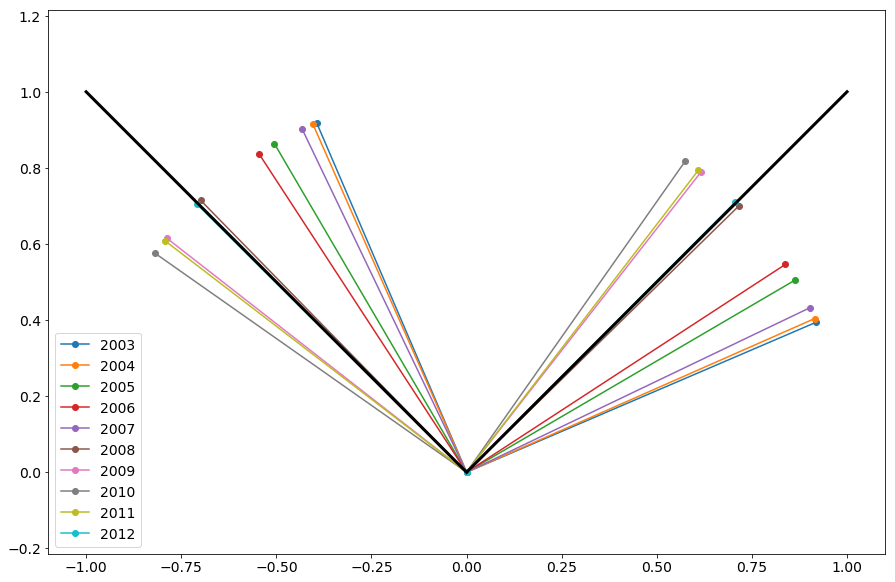

In [326]:
plt.figure(figsize=(15,10))
for i,y in enumerate(range(2003,2013)):
    w,v = lambdas(y)
    plt.plot([0,v[0,0]],[0,v[1,0]],'o-',color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i%10],label=str(y))
    plt.plot([0,v[0,1]],[0,v[1,1]],'o-',color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i%10])
    plt.legend()
    plt.grid()
plt.plot([0,1],[0,1],'k',lw=3)
plt.plot([0,-1],[0,1],'k',lw=3)
# plt.xlim(0,1.3)
# plt.ylim(0,1.3)
plt.axis('equal')

In [ ]:
# aszimmetria a kuldesben es a fogadasban?

In [327]:
res.value = res.value.map(float)
res[(res["model_part"]=="model_w_ij")]

,model_part,variable,value,std_error,significance,year
0,model_w_ij,log_d_ij,-2.4210,0.12100,3.0,2002
1,model_w_ij,log_P_i,-9.7990,2.25900,3.0,2002
2,model_w_ij,log_P_j,-1.7910,2.06200,0.0,2002
3,model_w_ij,log_P_i_2,1.1150,0.12200,3.0,2002
4,model_w_ij,log_P_j_2,0.3440,0.09880,3.0,2002
5,model_w_ij,log_P_i_log_P_j,0.3180,0.21900,0.0,2002
6,model_w_ij,_cons,15.5500,10.92000,0.0,2002
0,model_w_ij,log_d_ij,-2.0300,0.08980,3.0,2003
1,model_w_ij,log_P_i,-9.6820,1.08200,3.0,2003
2,model_w_ij,log_P_j,-3.6880,1.19600,3.0,2003


### coefficients in the quadratic form

In [101]:
res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value")

variable,_cons,log_P_i,log_P_i_2,log_P_i_log_P_j,log_P_j,log_P_j_2,log_d_ij
year,,,,,,,
2002,15.550,-9.79900,1.1150,0.318,-1.791,0.3440,-2.421
2003,22.220,-9.68200,0.9320,0.611,-3.688,0.3510,-2.030
2004,17.800,-8.23000,0.7680,0.601,-2.632,0.2200,-1.812
2005,9.636,-5.01500,0.5070,0.553,-2.032,0.1960,-2.115
2006,-1.292,-1.22300,0.2680,0.331,-0.147,0.1220,-3.198
2007,-2.629,-0.66500,0.2430,0.221,0.715,0.0653,-3.696
2008,-1.821,0.00509,0.1640,0.180,-0.219,0.1600,-3.607
2009,-1.772,0.18700,0.1170,0.204,-0.512,0.1680,-3.400
2010,-2.685,0.49300,0.0769,0.192,-0.331,0.1460,-3.321


### eigvals and eccentricity

In [303]:
eigvals = pd.DataFrame([lambdas(y)[0] for y in range(2002,2013)],columns=["lambda1","lambda2"],index=range(2002,2013))
eigvals['ecc'] = np.sqrt(1-eigvals['lambda2']/eigvals['lambda1'])
eigvals

,lambda1,lambda2,ecc
2002,1.146503,0.312497,0.852898
2003,1.063069,0.219931,0.890571
2004,0.900665,0.087335,0.950280
2005,0.668726,0.034274,0.974037
2006,0.375885,0.014115,0.981044
2007,0.295941,0.012359,0.978896
2008,0.252022,0.071978,0.845221
2009,0.247639,0.037361,0.921484
2010,0.213478,0.009422,0.977683
2011,0.228243,-0.182743,1.341883


### quadratic surfaces and sections

In [328]:
plt.rcParams["font.size"] = 14
plt.rcParams['figure.facecolor'] = 'white'

In [ ]:
def plot_quad(year):
    params = res[(res["model_part"]=="model_w_ij")].pivot_table(index="year",columns="variable",values="value").loc[year]
    x = np.linspace(0,np.log(2e6),200)
    y = np.linspace(0,np.log(2e6),200)
    X,Y = np.meshgrid(x,y)
    
    def f(a,b):
        Z = params["log_P_i_2"]*a**2 + params["log_P_j_2"]*b**2 + params["log_P_i_log_P_j"]*a*b+params["log_P_i"]*a+params["log_P_j"]*b
        return Z
    
    # size of Budapest
    bp = np.log(2e6)
    # size of a small village
    v = np.log(200) 
    
    # 4-panel figure for each year
    fig,ax = plt.subplots(1,4,figsize=(24,5))
    
    # colors for different sections
    diag_colors = plt.cm.Greens(np.linspace(0.4,1,4))
    hcolors = plt.cm.Oranges(np.linspace(0.4,1,4))
    vcolors = plt.cm.Purples(np.linspace(0.4,1,4))
    
    for i,c in enumerate([np.log(10**k) for k in [6,8,10,12]]):
        # diagonal cuts
        tx = np.linspace(np.max([v,c-bp]),np.min([bp,c-v]))
        ty = c-tx
        
        ax[0].plot(tx,ty,'--',color=diag_colors[i], lw=4)
        
        # plotting cut values to next axis
        ax[1].plot(tx-ty,f(tx,ty),label=r'$P_S\cdot P_T=10^{%.0f}$' % np.log10(np.exp(c)),color=diag_colors[i], lw=2)
        yamin = np.argmin(f(tx,ty))
        ax[1].plot(tx[yamin]-ty[yamin],f(tx,ty)[yamin],'*',markersize=10,color=diag_colors[i], lw=2)
        
        # horizontal cuts
        tx = np.linspace(v,bp,200)
        ty = np.linspace(c/2,c/2,200)
        
#         ax[0].plot(tx,ty,'--',color=hcolors[i], lw=2)
        ax[2].plot(tx,f(tx,ty),label=r'$P_T=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
        # vertical cuts
#         ax[0].plot(ty,tx,'--',color=hcolors[i], lw=2)    
        ax[3].plot(tx,f(ty,tx),label=r'$P_S=10^{%.0f}$' % np.log10(np.exp(c/2)),color=hcolors[i], lw=2)

            
    ax[1].set_ylim(-100,200)
    ax[1].set_xlabel(r"$\log P_S - \log P_T$")
    ax[1].legend(ncol=2)
    
#     ax[2].set_ylim(-5,20)
    ax[2].set_xlim(v,bp)
    ax[2].set_xlabel(r"$\log P_S$")
    ax[2].legend(ncol=2)
    
#     ax[3].set_ylim(-5,20)
    ax[3].set_xlim(v,bp)
    ax[3].set_xlabel(r"$\log P_T$")
    ax[3].legend(ncol=2)
    
    ax[0].set_xlabel(r"$\log P_S$")
    ax[0].set_ylabel(r"$\log P_T$")
    
    # plotting the function itseld
    ax[0].contour(X,Y,f(X,Y),cmap='inferno',linewidths=7, levels=20)
    ax[0].set_title(str(year))
    ax[0].set_ylim(v,bp)
    ax[0].set_xlim(v,bp)
    
    plt.show()

$$\log w \sim \alpha \log P_i^2 + \beta \log P_i \log P_j + \gamma \log P_j^2 + \delta \log P_i +\varepsilon \log P_j + \chi \log d + C$$

$$\frac{\log w}{\log P_i} = 2\alpha \log P_i + \beta \log P_j + \delta$$
$$\frac{\log w}{\log P_j} = 2\gamma \log P_j + \beta \log P_i + \varepsilon$$

In [ ]:
# cimkezni a 2-4. y-tengelyt
# ha egyenes szintvonalak lennenek -> hatvanyfuggveny
# ha paraboloid -> a nagyobb telepulesek dominaljak a kuldest
# ha paraboloid -> nehezen kuldenek a sajatjuktol eltero meretre a telepulesek
# a nagytelepulesek a targetek
# ha hiperboloid -> a kisebb telepulesek dominaljak a kuldest, ok fognak le nagy meretskalat!
# a kistelepulesek a targetek
# ha hiperboloid -> a sajatjuktol eltero merettartomanyban "konnyebb" kuldeni

# akkor a kistelepulesek a laggardok
# viselkedesuk a kesobbi idoszakban dominal

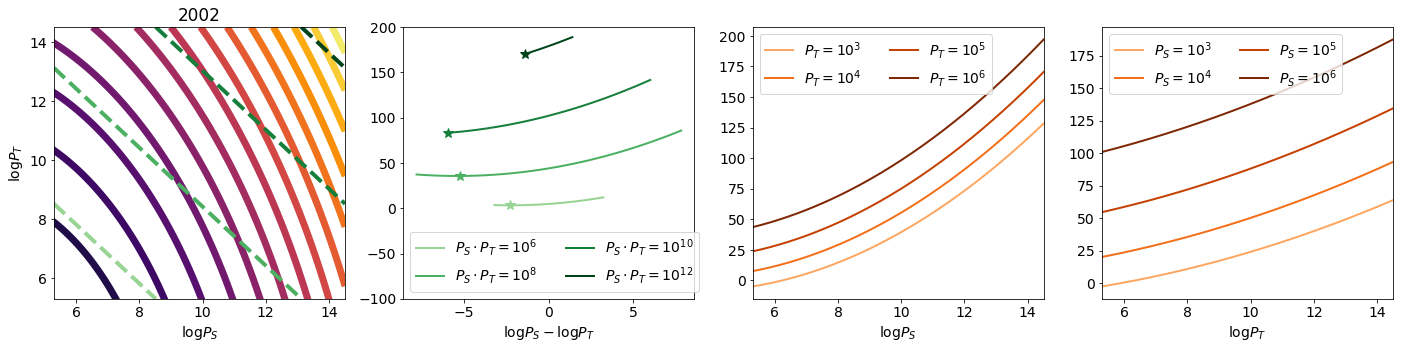

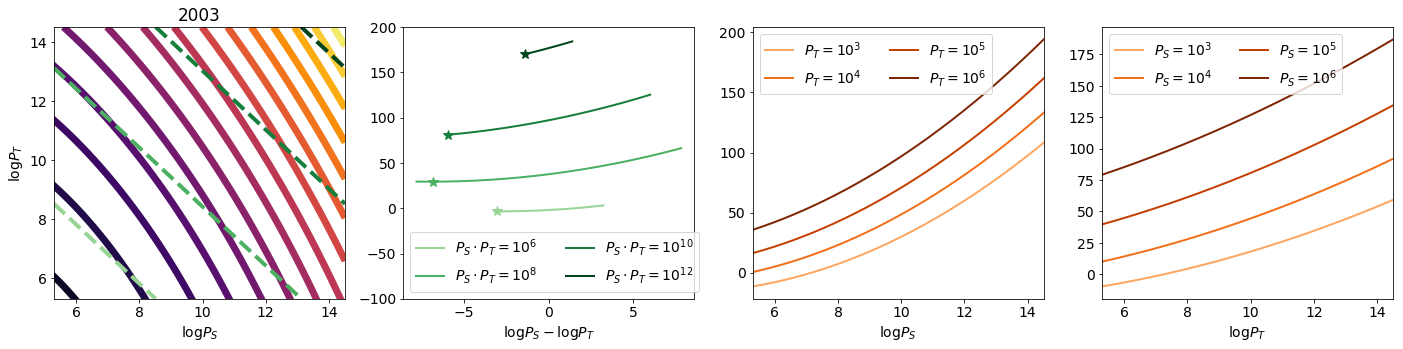

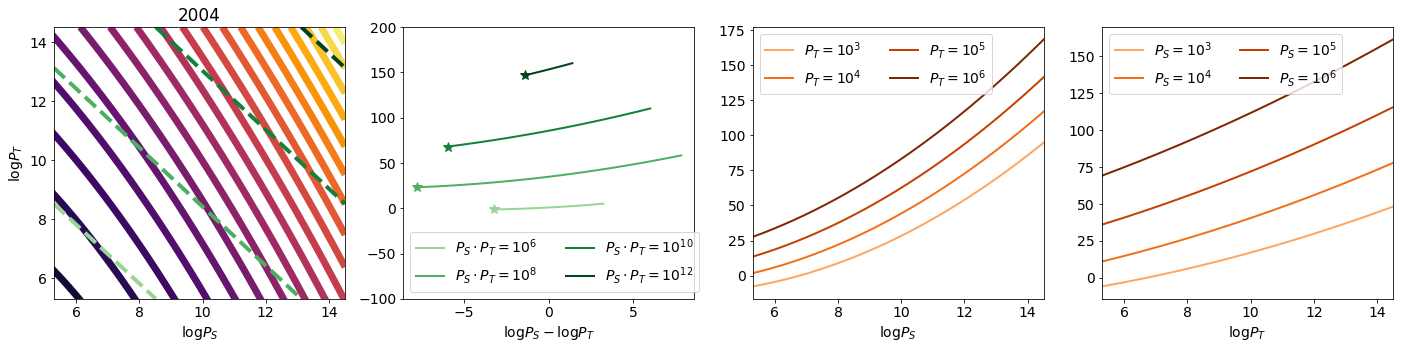

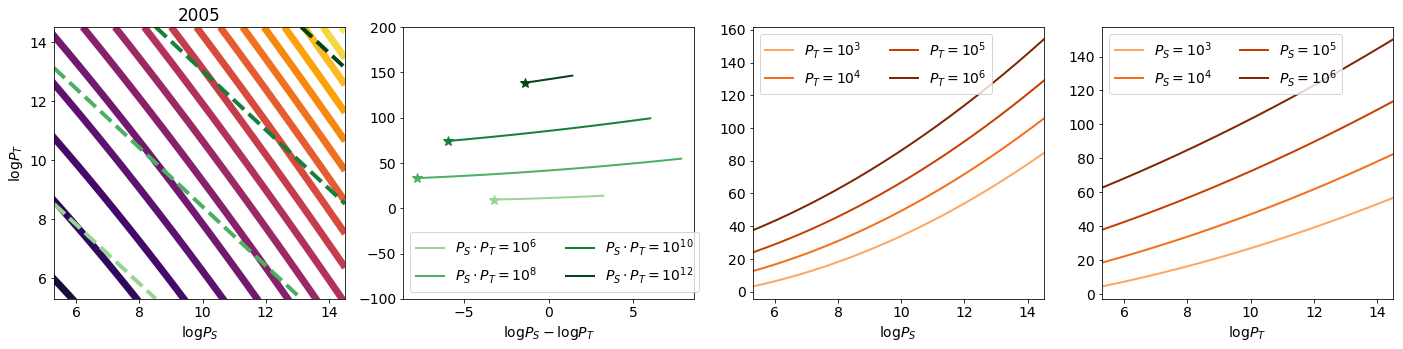

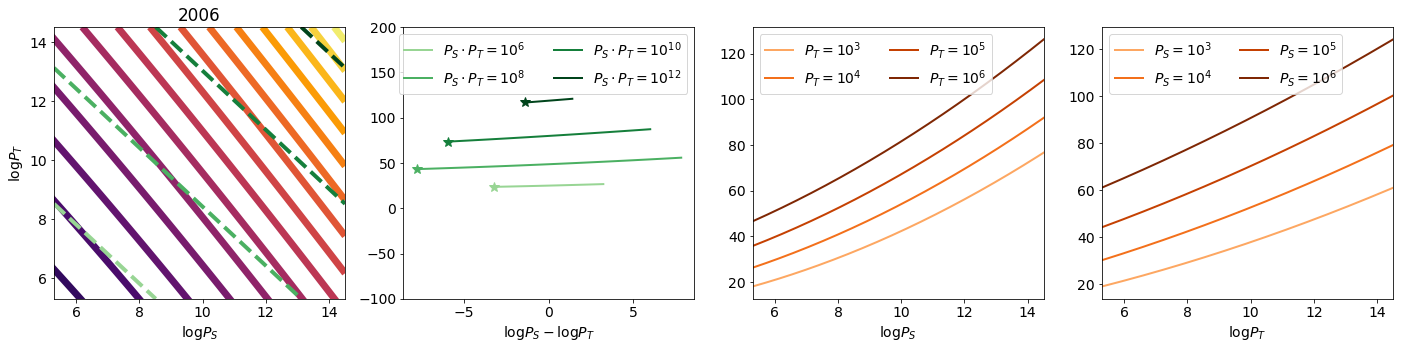

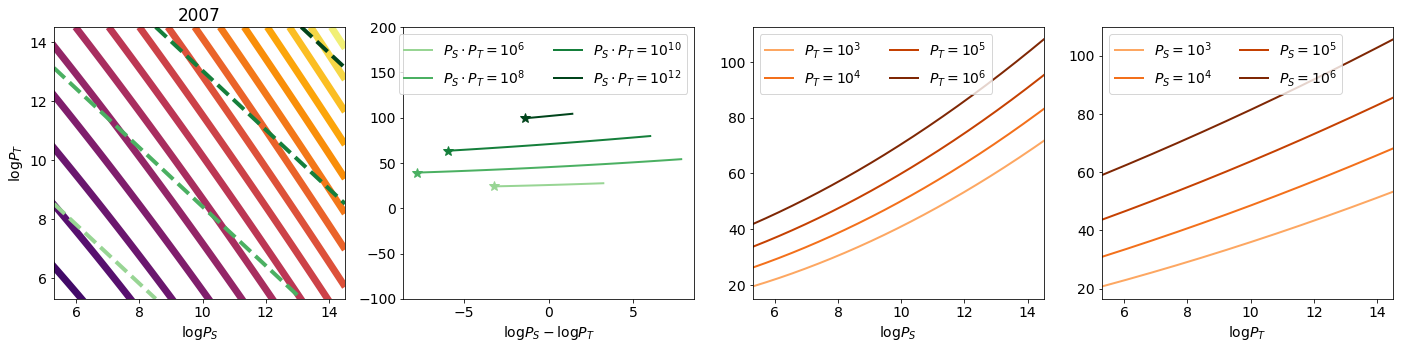

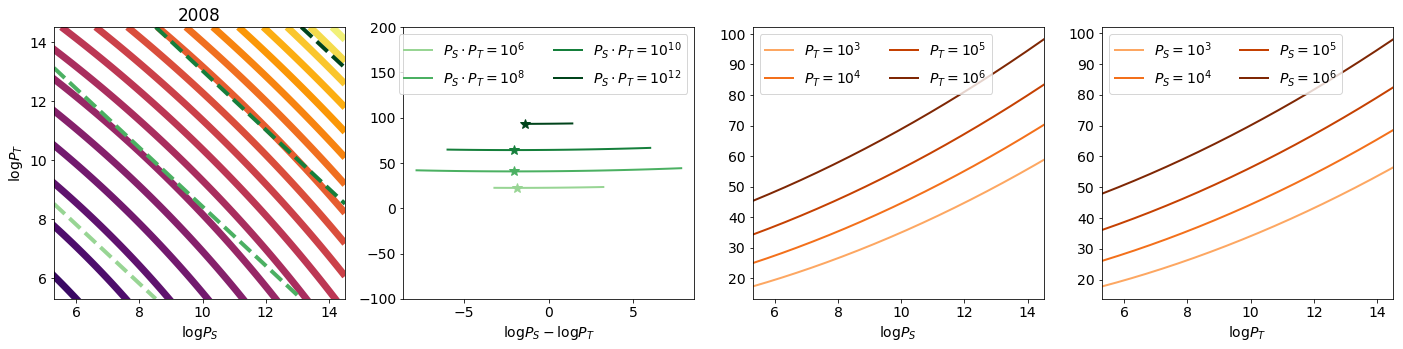

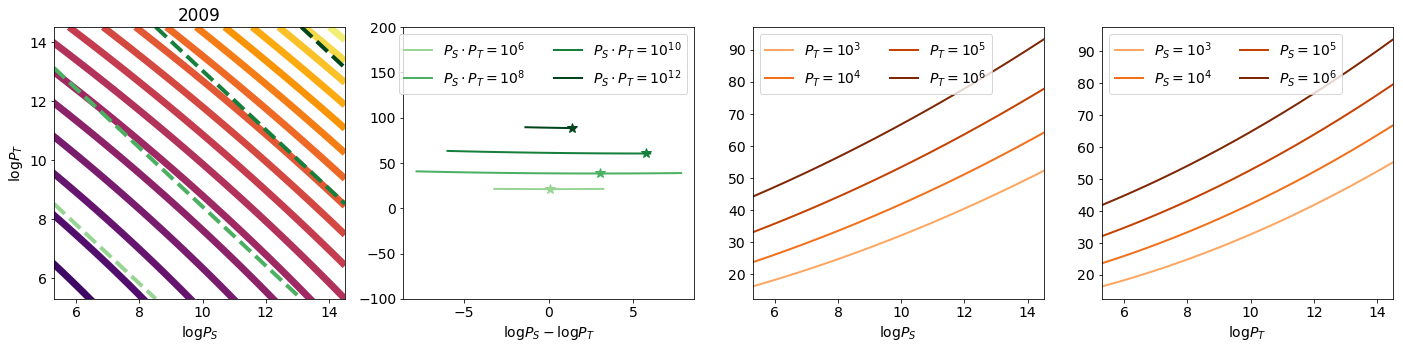

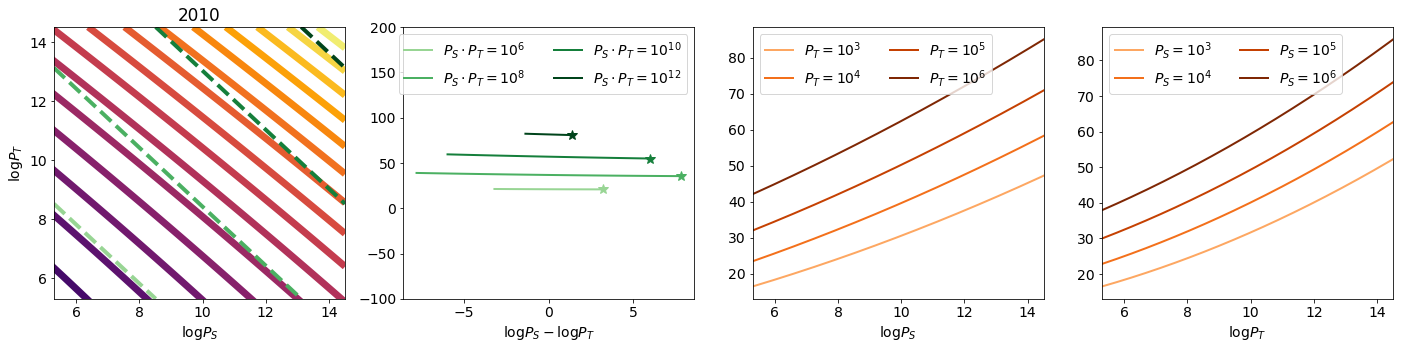

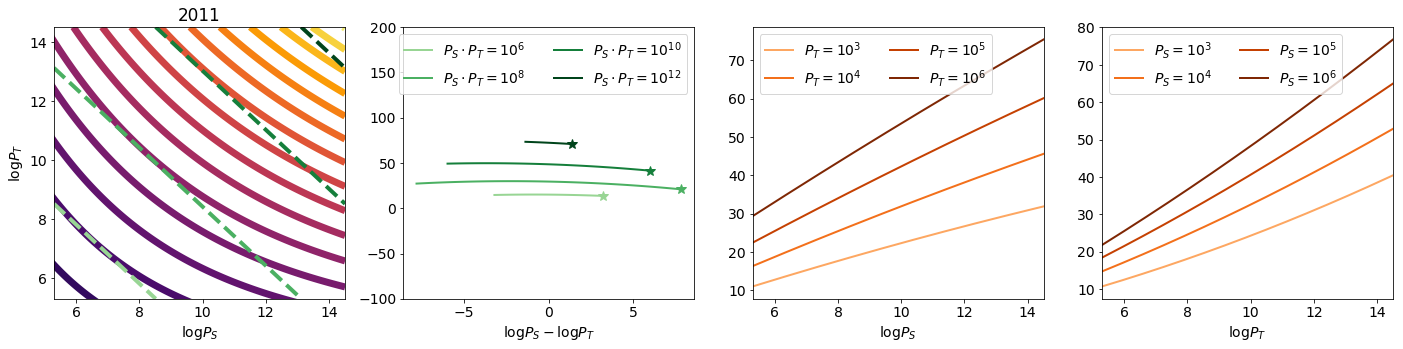

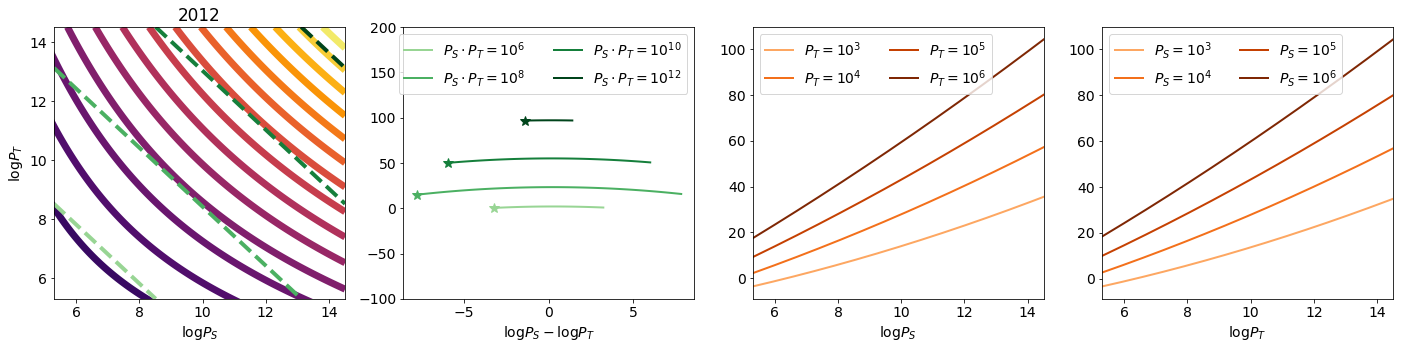

In [322]:
for y in range(2002,2013):
    plot_quad(y)